In [1]:
import os
import math
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
from fk import params
from fk import model
from fk import convert
from fk import stimulus

In [2]:
def show_figure(states, times, figsize, dt, rows=5):
    cols = math.ceil((len(states) / rows))
    fig, ax = plt.subplots(cols, rows, figsize=figsize)
    idx = 0
    for col in range(cols):
        for row in range(rows):
            if idx >= len(states):
                return
            ax[col, row].imshow(states[idx], cmap="magma", vmin=0, vmax=1,)
            ax[col, row].set_title("Iter: " + str(times[idx + 1]) + " (%sms)" % convert.units_to_ms(times[idx + 1], dt))
            idx += 1

In [3]:
# simulation inputs (real values)
field_size = (8.85, 8.85)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = params.params9()

In [4]:
# infinitesimals
dx = 0.015  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.02  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

(590, 590)
real tissue size: (8.85, 8.85)
Checkpointing at: [0, 500, 3500, 7500, 10000, 13000, 15000, 16800, 17250, 17750, 19650, 20150, 23000, 23750, 24750, 25500, 26250, 28750, 31250, 45500, 55750, 58000, 60500, 63000, 65000, 67000, 69500, 71000, 74000, 76500, 80000, 83500]
{'tau_v_plus': 3.33, 'tau_v1_minus': 15, 'tau_v2_minus': 2, 'tau_w_plus': 670, 'tau_w_minus': 61, 'tau_d': 0.25, 'tau_0': 12.5, 'tau_r': 28, 'tau_si': 29, 'k': 10, 'V_csi': 0.45, 'V_c': 0.13, 'V_v': 0.05, 'Cm': 1}


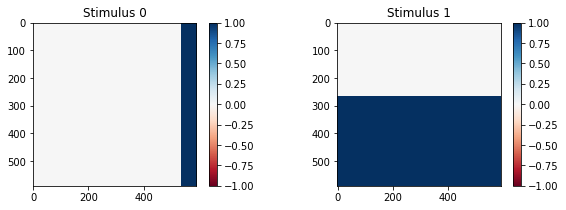

In [5]:
# to computational units
shape = convert.field_to_shape(field_size, dx)

stripe_size = int(shape[0] / 10)

protocol1 = stimulus.protocol(start=0, duration=2, period=0)
s1 = stimulus.rectangular(shape, jax.ops.index[:, -stripe_size:], 1., protocol1)

protocol2 = stimulus.protocol(start=convert.ms_to_units(140, dt), duration=2, period=0)
s2 = stimulus.rectangular(shape, jax.ops.index[convert.cm_to_units(4, dx):], 1., protocol2)

stimuli = [s1, s2]

checkpoints = [0, 10, 70, 150, 200, 260, 300, 336, 345, 355, 393, 403, 460, 475, 495, 510, 525, 575, 625, 910, 1115, 1160, 1210, 1260, 1300, 1340, 1390, 1420, 1480, 1530, 1600, 1670]
checkpoints = [convert.ms_to_units(ck, dt) for ck in checkpoints]

print(shape)
print("real tissue size:", field_size)
print("Checkpointing at:", checkpoints)
print(cell_parameters)
model.show_stimuli(*stimuli)

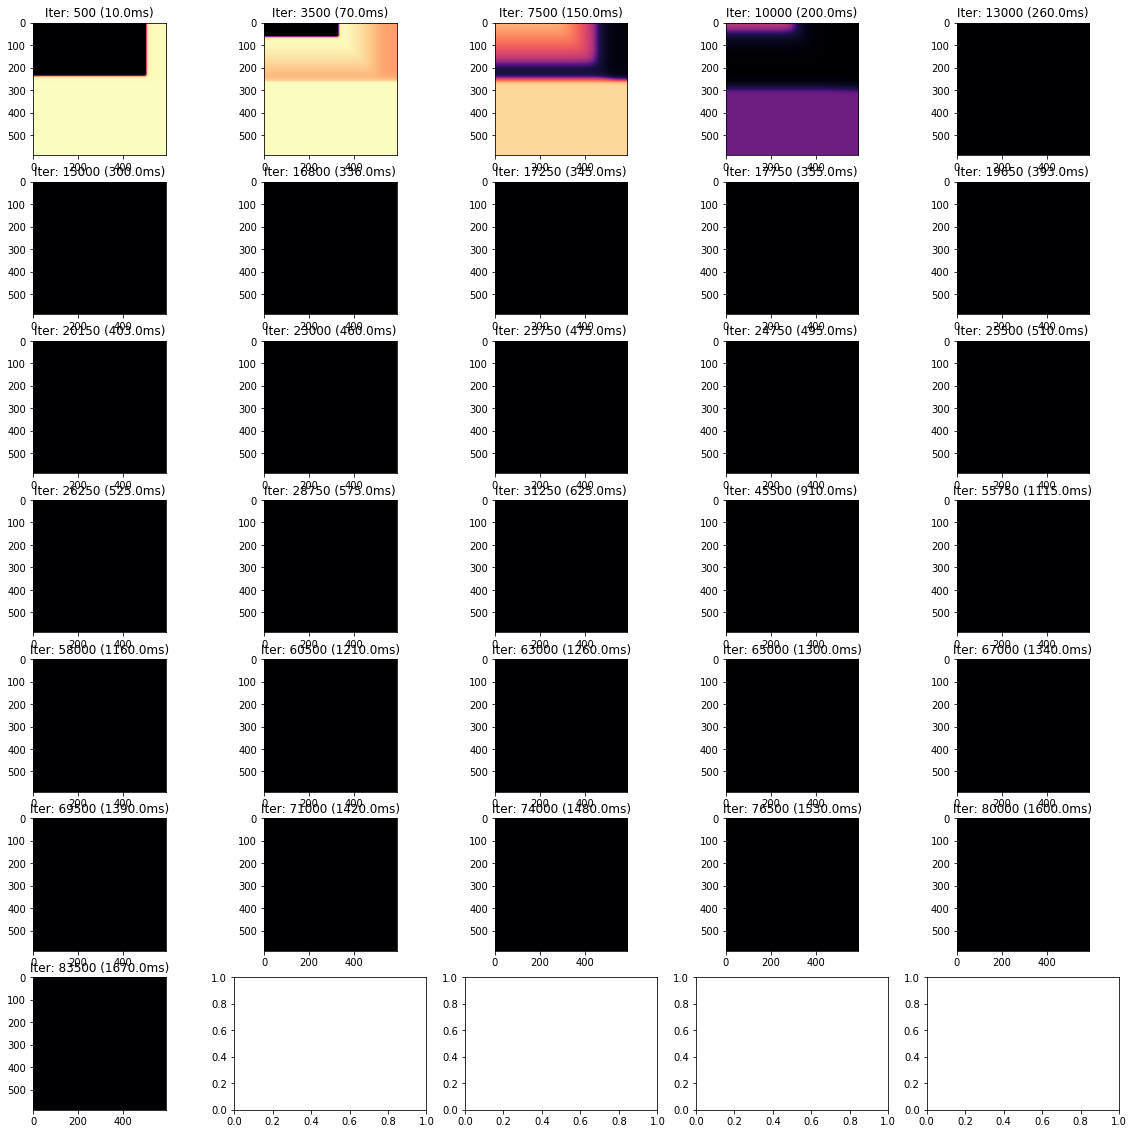

In [6]:
state = model.init(shape)
states = []
for i in range(len(checkpoints) - 1):
    state = model._forward(state, checkpoints[i], checkpoints[i + 1], cell_parameters, np.ones(shape) * d, stimuli, dt, dx)
    u = state[2]
    states.append(u)
#     model.show(state)
          
show_figure(states, checkpoints, (20, 20), dt)